In [ ]:
# CELL 1: Imports + Load Data

import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

# Paths
PATH_LENDING = "Lending_Behavior_Dataset.csv"
PATH_SIGNALS = "financial_signals.csv"
PATH_REVIEWS = "app_reviews.csv"
PATH_SURVEY  = "bank-lending-survey-results-january-2003---july-2025.xlsx"
PATH_EXTRA   = "SIA147.20250726T160733.csv"

# Load datasets
lending_df = pd.read_csv(PATH_LENDING)
signals_df = pd.read_csv(PATH_SIGNALS)
reviews_df = pd.read_csv(PATH_REVIEWS)
extra_df   = pd.read_csv(PATH_EXTRA)

# Survey file has multiple sheets
survey_mean_df = pd.read_excel(PATH_SURVEY, sheet_name="Mean Responses")
survey_diff_df = pd.read_excel(PATH_SURVEY, sheet_name="Diffusion Index Responses")

# Print shapes and column names
print("Dataset Shapes:")
print("lending_df:     ", lending_df.shape)
print("signals_df:     ", signals_df.shape)
print("reviews_df:     ", reviews_df.shape)
print("extra_df:       ", extra_df.shape)
print("survey_mean_df: ", survey_mean_df.shape)
print("survey_diff_df: ", survey_diff_df.shape)

print("\n--- Lending Columns ---")
print(lending_df.columns.tolist())

print("\n--- Signals Columns ---")
print(signals_df.columns.tolist())

print("\n--- Reviews Columns ---")
print(reviews_df.columns.tolist())

print("\n--- Extra Financial Columns ---")
print(extra_df.columns.tolist())

print("\n--- Survey Mean Columns (first 20) ---")
print(survey_mean_df.columns.tolist()[:20])

print("\n--- Survey Diffusion Columns (first 20) ---")
print(survey_diff_df.columns.tolist()[:20])


Dataset Shapes:
lending_df:      (35000, 8)
signals_df:      (1713, 7)
reviews_df:      (50000, 6)
extra_df:        (180, 6)
survey_mean_df:  (99, 256)
survey_diff_df:  (96, 256)

--- Lending Columns ---
['user_id', 'date', 'region', 'age_group', 'app_used', 'loan_amount', 'missed_payments', 'behavior_risk_flag']

--- Signals Columns ---
['date', 'region', 'age_group', 'consumer_sentiment_index', 'bnpl_search_index', 'debt_to_income_ratio', 'avg_savings_rate']

--- Reviews Columns ---
['review_id', 'date', 'app_name', 'region', 'rating', 'review_text']

--- Extra Financial Columns ---
['Statistic Label', 'Year', 'Financial situation at end of month', 'Household Composition', 'UNIT', 'VALUE']

--- Survey Mean Columns (first 20) ---
['Unnamed: 0', 'Question 1: Changes in Credit Standards on Loans to Enterprises', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Question 2 Factors Affecting Credit Standards on Loans to Enterprises: Overall', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9

In [ ]:
# Convert date fields
lending_df["date"] = pd.to_datetime(lending_df["date"], errors="coerce")
signals_df["date"] = pd.to_datetime(signals_df["date"], errors="coerce")
reviews_df["date"] = pd.to_datetime(reviews_df["date"], errors="coerce")

# Quick look at structure to confirm nothing broke during conversion
print("Lending dtypes:")
print(lending_df.dtypes)
print("\nLending sample:")
print(lending_df.head())

print("\nSignals dtypes:")
print(signals_df.dtypes)
print("\nSignals sample:")
print(signals_df.head())

print("\nReviews dtypes:")
print(reviews_df.dtypes)
print("\nReviews sample:")
print(reviews_df.head())

# Checking key categorical fields before merging later
print("\nUnique regions in lending:", lending_df["region"].unique())
print("Unique age_groups in lending:", lending_df["age_group"].unique())
print("Unique apps in lending:", lending_df["app_used"].unique()[:20])
print("Unique app_names in reviews:", reviews_df["app_name"].unique()[:20])


Lending dtypes:
user_id                       object
date                  datetime64[ns]
region                        object
age_group                     object
app_used                      object
loan_amount                  float64
missed_payments                int64
behavior_risk_flag             int64
dtype: object

Lending sample:
  user_id                          date     region age_group app_used  loan_amount  missed_payments  behavior_risk_flag
0  U15723 2018-01-01 00:00:00.000000000       Cork     18-24   Klarna       258.27                0                   0
1  U15417 2018-01-01 01:45:09.848852824     Dublin     25-34  Revolut       500.18                0                   0
2  U89187 2018-01-01 03:30:19.697705648     Dublin     18-24  Revolut       882.69                0                   0
3  U82732 2018-01-01 05:15:29.546558473     Dublin     45-54  FlexiFi      2520.46                0                   0
4  U29082 2018-01-01 07:00:39.395411297  Waterford     45

In [ ]:
# Focusing only on Dublin
lending_df = lending_df[lending_df["region"] == "Dublin"].copy()
signals_df = signals_df[signals_df["region"] == "Dublin"].copy()
reviews_df = reviews_df[reviews_df["region"] == "Dublin"].copy()

# Add sentiment scores for reviews (Dublin only now)
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()
reviews_df["sentiment"] = reviews_df["review_text"].fillna("").apply(
    lambda x: sia.polarity_scores(x)["compound"]
)

# Group monthly sentiment per app
reviews_df["year_month"] = reviews_df["date"].dt.to_period("M").astype(str)

sentiment_grouped = (
    reviews_df.groupby(["app_name", "year_month"])["sentiment"]
    .mean()
    .reset_index()
    .rename(columns={"app_name": "app_used", "sentiment": "sentiment_score"})
)

print("Sentiment grouped sample:")
print(sentiment_grouped.head())
print("\nShape:", sentiment_grouped.shape)

print("\nRemaining lending rows after Dublin filter:", lending_df.shape)
print("Remaining signals rows:", signals_df.shape)
print("Remaining reviews rows:", reviews_df.shape)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aakas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sentiment grouped sample:
  app_used year_month  sentiment_score
0  AIB App    2018-01         0.335825
1  AIB App    2018-02         0.238053
2  AIB App    2018-03         0.316882
3  AIB App    2018-04         0.412107
4  AIB App    2018-05         0.013145

Shape: (504, 3)

Remaining lending rows after Dublin filter: (13896, 8)
Remaining signals rows: (342, 7)
Remaining reviews rows: (20002, 8)


In [9]:
# Add a year_month field to lending to match sentiment data
lending_df["year_month"] = lending_df["date"].dt.to_period("M").astype(str)

# Merge lending with signals (behavioral indicators)
lending_merged = lending_df.merge(
    signals_df,
    on=["date", "region", "age_group"],
    how="left"
)

# Merge lending with monthly sentiment (app behavior indicator)
lending_merged = lending_merged.merge(
    sentiment_grouped,
    on=["app_used", "year_month"],
    how="left"
)

# Prepare macro indicator from extra_df
extra_df_clean = extra_df[["Year", "VALUE"]].copy()
extra_df_clean = extra_df_clean.rename(columns={"VALUE": "financial_pressure_index"})

# Extract year from lending date
lending_merged["year"] = lending_merged["date"].dt.year

# Merge yearly macro indicator
lending_merged = lending_merged.merge(
    extra_df_clean,
    left_on="year",
    right_on="Year",
    how="left"
)

# Remove duplicate year column
lending_merged = lending_merged.drop(columns=["Year"])

print("Merged dataset shape:", lending_merged.shape)
print("\nSample of merged data:")
print(lending_merged.head())


Merged dataset shape: (361096, 16)

Sample of merged data:
  user_id                          date  region age_group app_used  loan_amount  missed_payments  behavior_risk_flag year_month  consumer_sentiment_index  bnpl_search_index  debt_to_income_ratio  \
0  U15417 2018-01-01 01:45:09.848852824  Dublin     25-34  Revolut       500.18                0                   0    2018-01                       NaN                NaN                   NaN   
1  U89187 2018-01-01 03:30:19.697705648  Dublin     18-24  Revolut       882.69                0                   0    2018-01                       NaN                NaN                   NaN   
2  U82732 2018-01-01 05:15:29.546558473  Dublin     45-54  FlexiFi      2520.46                0                   0    2018-01                       NaN                NaN                   NaN   
3  U64596 2018-01-01 08:45:49.244264121  Dublin       55+  AIB App       383.17                0                   0    2018-01                      

In [ ]:
# Prepare year_month for both lending and signals
lending_df["year_month"] = lending_df["date"].dt.to_period("M").astype(str)
signals_df["year_month"] = signals_df["date"].dt.to_period("M").astype(str)

# Merge lending with signals on monthly level instead of exact date
lending_signals = lending_df.merge(
    signals_df.drop(columns=["date"]), 
    on=["region", "age_group", "year_month"], 
    how="left"
)

# Merge monthly sentiment
lending_signals = lending_signals.merge(
    sentiment_grouped,
    on=["app_used", "year_month"],
    how="left"
)

# Clean extra_df year column
extra_df_clean = extra_df.copy()
extra_df_clean["Year"] = pd.to_numeric(extra_df_clean["Year"], errors="coerce")

macro = extra_df_clean[["Year", "VALUE"]].rename(columns={"VALUE": "financial_pressure_index"})

# Extract year from lending
lending_signals["year"] = lending_signals["date"].dt.year

# Yearly merge
lending_signals = lending_signals.merge(
    macro, 
    left_on="year", 
    right_on="Year", 
    how="left"
).drop(columns=["Year"])

print("Shape after fixed merges:", lending_signals.shape)
print("\nSample rows:")
print(lending_signals.head())


Shape after fixed merges: (361096, 16)

Sample rows:
  user_id                          date  region age_group app_used  loan_amount  missed_payments  behavior_risk_flag year_month  consumer_sentiment_index  bnpl_search_index  debt_to_income_ratio  \
0  U15417 2018-01-01 01:45:09.848852824  Dublin     25-34  Revolut       500.18                0                   0    2018-01                 76.441028               98.0              0.476842   
1  U89187 2018-01-01 03:30:19.697705648  Dublin     18-24  Revolut       882.69                0                   0    2018-01                       NaN                NaN                   NaN   
2  U82732 2018-01-01 05:15:29.546558473  Dublin     45-54  FlexiFi      2520.46                0                   0    2018-01                 82.697026               89.0              0.893234   
3  U64596 2018-01-01 08:45:49.244264121  Dublin       55+  AIB App       383.17                0                   0    2018-01                 84.382492  

In [ ]:
# Aggregate signals monthly to avoid many-to-many joins
signals_df["year_month"] = signals_df["date"].dt.to_period("M").astype(str)

signals_monthly = (
    signals_df
    .groupby(["region", "age_group", "year_month"], as_index=False)[
        ["consumer_sentiment_index", "bnpl_search_index", "debt_to_income_ratio", "avg_savings_rate"]
    ]
    .mean()
)

print("Signals_monthly shape:", signals_monthly.shape)

# Base: Dublin lending with year_month
lending_base = lending_df.copy()
lending_base["year_month"] = lending_base["date"].dt.to_period("M").astype(str)

# Merge lending + monthly signals
merged = lending_base.merge(
    signals_monthly,
    on=["region", "age_group", "year_month"],
    how="left"
)

# Merge lending + monthly sentiment
merged = merged.merge(
    sentiment_grouped,
    on=["app_used", "year_month"],
    how="left"
)

macro = extra_df.copy()
macro["Year"] = pd.to_numeric(macro["Year"], errors="coerce")
macro = macro[["Year", "VALUE"]].rename(columns={"VALUE": "financial_pressure_index"})

merged["year"] = merged["date"].dt.year

merged = merged.merge(
    macro,
    left_on="year",
    right_on="Year",
    how="left"
).drop(columns=["Year"])

print("\nFinal merged shape:", merged.shape)
print("\nSample rows:")
print(merged.head())

# Quick look at missingness for new numeric features
num_cols = ["consumer_sentiment_index", "bnpl_search_index", "debt_to_income_ratio",
            "avg_savings_rate", "sentiment_score", "financial_pressure_index"]

print("\nMissing value ratio for key numeric features:")
print(merged[num_cols].isna().mean().round(3))


Signals_monthly shape: (342, 7)



Final merged shape: (361096, 16)

Sample rows:
  user_id                          date  region age_group app_used  loan_amount  missed_payments  behavior_risk_flag year_month  consumer_sentiment_index  bnpl_search_index  debt_to_income_ratio  \
0  U15417 2018-01-01 01:45:09.848852824  Dublin     25-34  Revolut       500.18                0                   0    2018-01                 76.441028               98.0              0.476842   
1  U89187 2018-01-01 03:30:19.697705648  Dublin     18-24  Revolut       882.69                0                   0    2018-01                       NaN                NaN                   NaN   
2  U82732 2018-01-01 05:15:29.546558473  Dublin     45-54  FlexiFi      2520.46                0                   0    2018-01                 82.697026               89.0              0.893234   
3  U64596 2018-01-01 08:45:49.244264121  Dublin       55+  AIB App       383.17                0                   0    2018-01                 84.382492       

In [ ]:
# Re-aggregate sentiment to ensure no duplicate key combinations
sentiment_grouped = (
    reviews_df.groupby(["app_name", "year_month"])["sentiment"]
    .mean()
    .reset_index()
    .rename(columns={"app_name": "app_used", "sentiment": "sentiment_score"})
)

# Verify the group is unique
duplicates = sentiment_grouped.duplicated(subset=["app_used", "year_month"]).sum()
print("Duplicate sentiment rows:", duplicates)

# Recreate the merged dataset cleanly
lending_base = lending_df.copy()
lending_base["year_month"] = lending_base["date"].dt.to_period("M").astype(str)

# Merge lending + monthly signals
merged = lending_base.merge(
    signals_monthly,
    on=["region", "age_group", "year_month"],
    how="left"
)

# Merge lending + cleaned sentiment
merged = merged.merge(
    sentiment_grouped,
    on=["app_used", "year_month"],
    how="left"
)

# Prepare yearly macro indicator
macro = extra_df.copy()
macro["Year"] = pd.to_numeric(macro["Year"], errors="coerce")
macro = macro[["Year", "VALUE"]].rename(columns={"VALUE": "financial_pressure_index"})

merged["year"] = merged["date"].dt.year

merged = merged.merge(
    macro,
    left_on="year",
    right_on="Year",
    how="left"
).drop(columns=["Year"])

print("\nFINAL merged shape (should be close to lending rows):", merged.shape)
print(merged.head())


Duplicate sentiment rows: 0

FINAL merged shape (should be close to lending rows): (361096, 16)
  user_id                          date  region age_group app_used  loan_amount  missed_payments  behavior_risk_flag year_month  consumer_sentiment_index  bnpl_search_index  debt_to_income_ratio  \
0  U15417 2018-01-01 01:45:09.848852824  Dublin     25-34  Revolut       500.18                0                   0    2018-01                 76.441028               98.0              0.476842   
1  U89187 2018-01-01 03:30:19.697705648  Dublin     18-24  Revolut       882.69                0                   0    2018-01                       NaN                NaN                   NaN   
2  U82732 2018-01-01 05:15:29.546558473  Dublin     45-54  FlexiFi      2520.46                0                   0    2018-01                 82.697026               89.0              0.893234   
3  U64596 2018-01-01 08:45:49.244264121  Dublin       55+  AIB App       383.17                0                

In [ ]:
print("Original Dublin lending rows:", len(lending_df))

# Collapse macro data to one value per year (average financial pressure)
macro = extra_df.copy()
macro["Year"] = pd.to_numeric(macro["Year"], errors="coerce")

macro_year = (
    macro.groupby("Year", as_index=False)["VALUE"]
    .mean()
    .rename(columns={"VALUE": "financial_pressure_index"})
)

print("Macro_year shape (should be one row per year):", macro_year.shape)

# Rebuild modelling table cleanly from scratch

lending_base = lending_df.copy()
lending_base["year_month"] = lending_base["date"].dt.to_period("M").astype(str)

# 1) lending + monthly signals
merged = lending_base.merge(
    signals_monthly,
    on=["region", "age_group", "year_month"],
    how="left"
)

# 2) + monthly sentiment
merged = merged.merge(
    sentiment_grouped,
    on=["app_used", "year_month"],
    how="left"
)

# 3) + yearly macro indicator
merged["year"] = merged["date"].dt.year

merged = merged.merge(
    macro_year,
    left_on="year",
    right_on="Year",
    how="left"
).drop(columns=["Year"])

print("\nFinal merged shape:", merged.shape)
print(merged.head())


Original Dublin lending rows: 13896
Macro_year shape (should be one row per year): (5, 2)

Final merged shape: (13896, 16)
  user_id                          date  region age_group app_used  loan_amount  missed_payments  behavior_risk_flag year_month  consumer_sentiment_index  bnpl_search_index  debt_to_income_ratio  \
0  U15417 2018-01-01 01:45:09.848852824  Dublin     25-34  Revolut       500.18                0                   0    2018-01                 76.441028               98.0              0.476842   
1  U89187 2018-01-01 03:30:19.697705648  Dublin     18-24  Revolut       882.69                0                   0    2018-01                       NaN                NaN                   NaN   
2  U82732 2018-01-01 05:15:29.546558473  Dublin     45-54  FlexiFi      2520.46                0                   0    2018-01                 82.697026               89.0              0.893234   
3  U64596 2018-01-01 08:45:49.244264121  Dublin       55+  AIB App       383.17      

In [14]:
# Quick overview of the final modelling table

print("Merged shape:", merged.shape)
print("\nColumns:")
print(merged.columns.tolist())

print("\nTarget distribution (behavior_risk_flag):")
print(merged["behavior_risk_flag"].value_counts(normalize=True).round(3))

print("\nDate range:")
print(merged["date"].min(), "to", merged["date"].max())

num_cols = [
    "loan_amount",
    "missed_payments",
    "consumer_sentiment_index",
    "bnpl_search_index",
    "debt_to_income_ratio",
    "avg_savings_rate",
    "sentiment_score",
    "financial_pressure_index"
]

print("\nMissing value ratio for numeric columns:")
print(merged[num_cols].isna().mean().round(3))

print("\nUnique age_groups:", merged["age_group"].unique())
print("Unique apps:", merged["app_used"].unique())


Merged shape: (13896, 16)

Columns:
['user_id', 'date', 'region', 'age_group', 'app_used', 'loan_amount', 'missed_payments', 'behavior_risk_flag', 'year_month', 'consumer_sentiment_index', 'bnpl_search_index', 'debt_to_income_ratio', 'avg_savings_rate', 'sentiment_score', 'year', 'financial_pressure_index']

Target distribution (behavior_risk_flag):
behavior_risk_flag
0    0.983
1    0.017
Name: proportion, dtype: float64

Date range:
2018-01-01 01:45:09.848852824 to 2024-12-30 22:14:50.151147168

Missing value ratio for numeric columns:
loan_amount                 0.000
missed_payments             0.000
consumer_sentiment_index    0.189
bnpl_search_index           0.189
debt_to_income_ratio        0.189
avg_savings_rate            0.189
sentiment_score             0.000
financial_pressure_index    0.286
dtype: float64

Unique age_groups: ['25-34' '18-24' '45-54' '55+' '35-44']
Unique apps: ['Revolut' 'FlexiFi' 'AIB App' 'Humm' 'Klarna' 'Avant']


In [15]:
data = merged.copy()

# Basic engineered features
data["loan_per_month"] = data["loan_amount"] / 12
data["missed_payment_ratio"] = data["missed_payments"] / (data["missed_payments"] + 1)

# Extract simple date features
data["month"] = data["date"].dt.month
data["year"] = data["date"].dt.year

# Impute missing numeric values with median
num_cols = [
    "consumer_sentiment_index",
    "bnpl_search_index",
    "debt_to_income_ratio",
    "avg_savings_rate",
    "financial_pressure_index"
]

for col in num_cols:
    data[col] = data[col].fillna(data[col].median())

# Check final missingness
print("Remaining missing values:")
print(data.isna().mean().sort_values(ascending=False).head(10))

print("\nPrepared data shape:", data.shape)
print(data.head())


Remaining missing values:
user_id                     0.0
date                        0.0
region                      0.0
age_group                   0.0
app_used                    0.0
loan_amount                 0.0
missed_payments             0.0
behavior_risk_flag          0.0
year_month                  0.0
consumer_sentiment_index    0.0
dtype: float64

Prepared data shape: (13896, 19)
  user_id                          date  region age_group app_used  loan_amount  missed_payments  behavior_risk_flag year_month  consumer_sentiment_index  bnpl_search_index  debt_to_income_ratio  \
0  U15417 2018-01-01 01:45:09.848852824  Dublin     25-34  Revolut       500.18                0                   0    2018-01                 76.441028               98.0              0.476842   
1  U89187 2018-01-01 03:30:19.697705648  Dublin     18-24  Revolut       882.69                0                   0    2018-01                 84.311409               59.0              0.784620   
2  U82732 2

In [16]:
from sklearn.preprocessing import LabelEncoder

data_model = data.copy()

# Encode simple categorical columns
cat_cols = ["age_group", "app_used"]

encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    data_model[col] = le.fit_transform(data_model[col])
    encoders[col] = le

# Convert year_month to a numeric YYYYMM format
data_model["year_month_num"] = data_model["year_month"].str.replace("-", "").astype(int)

print("Encoding complete.")
print(data_model[["age_group", "app_used", "year_month", "year_month_num"]].head())


Encoding complete.
   age_group  app_used year_month  year_month_num
0          1         5    2018-01          201801
1          0         5    2018-01          201801
2          3         2    2018-01          201801
3          4         0    2018-01          201801
4          1         3    2018-01          201801


In [17]:
# Keep a copy for modelling
df = data_model.copy()

# Sort by date to respect natural timeline
df = df.sort_values("date")

# Split by year
train_df = df[df["year"] <= 2022]
test_df  = df[df["year"] >= 2023]

print("Train size:", train_df.shape)
print("Test size:", test_df.shape)

# Define features and target
target = "behavior_risk_flag"

features = [
    "loan_amount",
    "missed_payments",
    "consumer_sentiment_index",
    "bnpl_search_index",
    "debt_to_income_ratio",
    "avg_savings_rate",
    "sentiment_score",
    "financial_pressure_index",
    "loan_per_month",
    "missed_payment_ratio",
    "age_group",
    "app_used",
    "month",
    "year_month_num"
]

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

print("\nSelected feature count:", len(features))
print("Positive rate in train:", y_train.mean())
print("Positive rate in test:", y_test.mean())


Train size: (9957, 20)
Test size: (3939, 20)

Selected feature count: 14
Positive rate in train: 0.016772120116500953
Positive rate in test: 0.01624777862401625


In [20]:
from xgboost import XGBClassifier

# Calculate imbalance weight
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale = neg / pos

print("Scale_pos_weight:", scale)

# Build the model
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    scale_pos_weight=scale,
    random_state=42
)

model.fit(X_train, y_train)

print("Model training complete.")

Scale_pos_weight: 58.622754491017965
Model training complete.


In [21]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    average_precision_score, confusion_matrix
)

# Model predictions
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)

# Metrics
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
pr_auc = average_precision_score(y_test, y_pred_prob)
cm = confusion_matrix(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("PR-AUC:", pr_auc)
print("\nConfusion Matrix:\n", cm)

Precision: 1.0
Recall: 1.0
F1 Score: 1.0
PR-AUC: 1.0

Confusion Matrix:
 [[3875    0]
 [   0   64]]


In [22]:
import pandas as pd

corr = df[[
    "missed_payments",
    "missed_payment_ratio",
    "loan_amount",
    "consumer_sentiment_index",
    "bnpl_search_index",
    "debt_to_income_ratio",
    "avg_savings_rate",
    "sentiment_score",
    "financial_pressure_index",
    "age_group",
    "app_used",
    "behavior_risk_flag"
]].corr()["behavior_risk_flag"].sort_values(ascending=False)

print(corr)


behavior_risk_flag          1.000000
missed_payments             0.352624
missed_payment_ratio        0.255145
loan_amount                 0.174556
age_group                   0.022899
avg_savings_rate            0.005210
app_used                    0.002006
consumer_sentiment_index   -0.003070
sentiment_score            -0.006539
financial_pressure_index   -0.007275
bnpl_search_index          -0.007860
debt_to_income_ratio       -0.018836
Name: behavior_risk_flag, dtype: float64


c:\Users\aakas\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


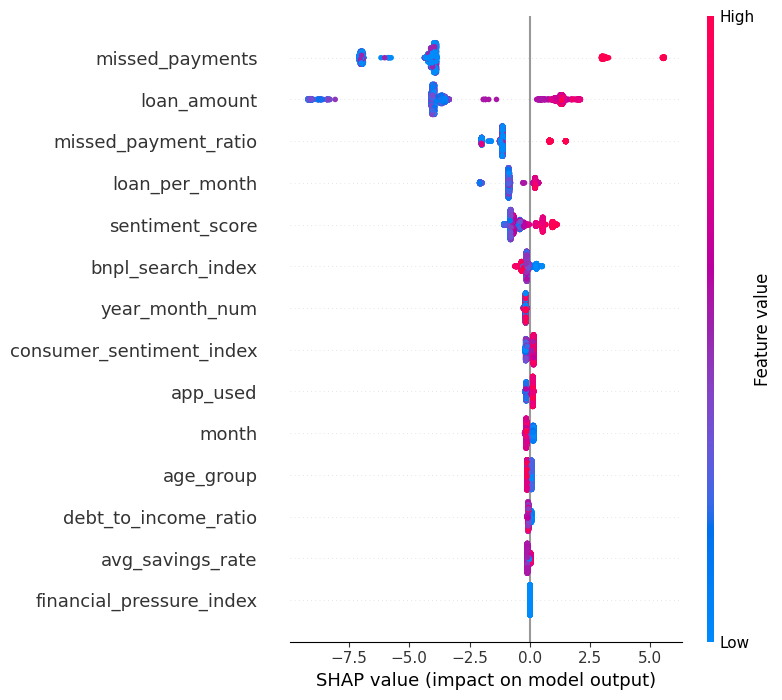

In [24]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Feature importance summary
shap.summary_plot(shap_values, X_test)


Example position in X_test: 1469
True label (behavior_risk_flag): 0
Predicted probability of risk: 0.00040955498


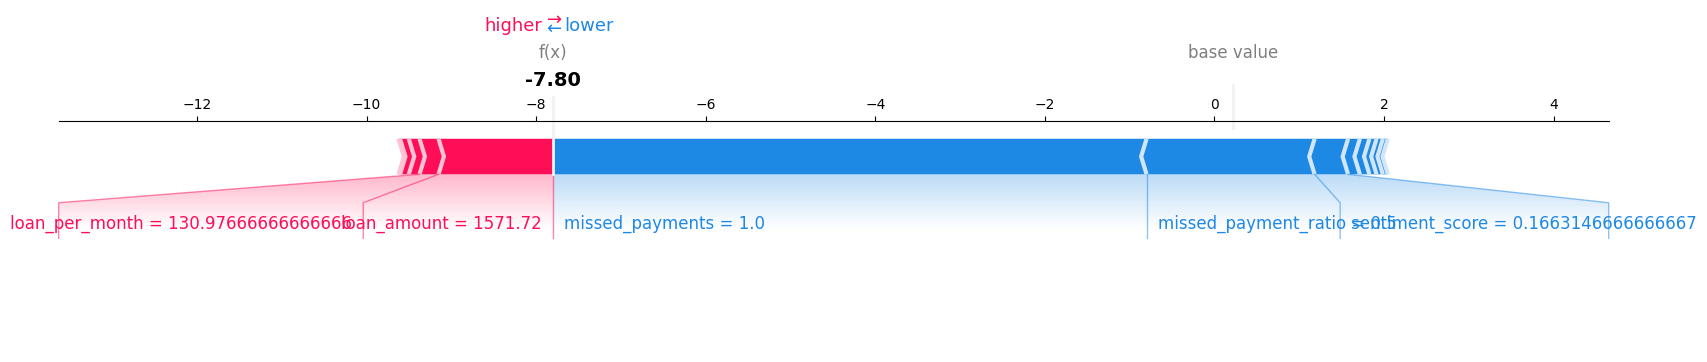

In [25]:
import numpy as np

# Pick a random position from X_test
pos = np.random.randint(0, X_test.shape[0])

row = X_test.iloc[pos]
row_shap = shap_values[pos]

print("Example position in X_test:", pos)
print("True label (behavior_risk_flag):", y_test.iloc[pos])
print("Predicted probability of risk:", y_pred_prob[pos])

shap.force_plot(
    explainer.expected_value,
    row_shap,
    row,
    matplotlib=True
)

In [26]:
test_df_copy = test_df.copy()
test_df_copy["pred"] = y_pred
test_df_copy["pred_prob"] = y_pred_prob

groups = test_df_copy["age_group"].unique()

results = []

for g in groups:
    subset = test_df_copy[test_df_copy["age_group"] == g]
    precision_g = precision_score(subset["behavior_risk_flag"], subset["pred"], zero_division=0)
    recall_g = recall_score(subset["behavior_risk_flag"], subset["pred"], zero_division=0)
    f1_g = f1_score(subset["behavior_risk_flag"], subset["pred"], zero_division=0)
    count_g = subset.shape[0]

    results.append({
        "age_group": g,
        "count": count_g,
        "precision": precision_g,
        "recall": recall_g,
        "f1": f1_g
    })

fairness_df = pd.DataFrame(results)
print(fairness_df)


   age_group  count  precision  recall   f1
0          4    418        1.0     1.0  1.0
1          2    972        1.0     1.0  1.0
2          1   1355        1.0     1.0  1.0
3          3    650        1.0     1.0  1.0
4          0    544        1.0     1.0  1.0


In [27]:
def train_eval_xgb(feature_list, label):
    Xtr = train_df[feature_list]
    Xte = test_df[feature_list]

    neg = (y_train == 0).sum()
    pos = (y_train == 1).sum()
    scale = neg / pos

    clf = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        scale_pos_weight=scale,
        random_state=42
    )

    clf.fit(Xtr, y_train)
    prob = clf.predict_proba(Xte)[:, 1]
    pred = (prob >= 0.5).astype(int)

    precision = precision_score(y_test, pred, zero_division=0)
    recall = recall_score(y_test, pred, zero_division=0)
    f1 = f1_score(y_test, pred, zero_division=0)
    pr_auc = average_precision_score(y_test, prob)

    return {
        "model": label,
        "n_features": len(feature_list),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "pr_auc": pr_auc
    }

# Feature sets
features_A = [
    "loan_amount",
    "age_group",
    "app_used",
    "month",
    "year_month_num",
    "financial_pressure_index"
]

features_B = features_A + [
    "consumer_sentiment_index",
    "bnpl_search_index",
    "debt_to_income_ratio",
    "avg_savings_rate"
]

features_C = features_B + [
    "sentiment_score",
    "loan_per_month",
    "missed_payments",
    "missed_payment_ratio"
]

results = []
results.append(train_eval_xgb(features_A, "A: baseline"))
results.append(train_eval_xgb(features_B, "B: + behavioural signals"))
results.append(train_eval_xgb(features_C, "C: full model (behaviour + sentiment)"))

results_df = pd.DataFrame(results)
print(results_df)


                                   model  n_features  precision    recall        f1    pr_auc
0                            A: baseline           6   0.088235  0.046875  0.061224  0.082143
1               B: + behavioural signals          10   0.000000  0.000000  0.000000  0.085675
2  C: full model (behaviour + sentiment)          14   1.000000  1.000000  1.000000  1.000000


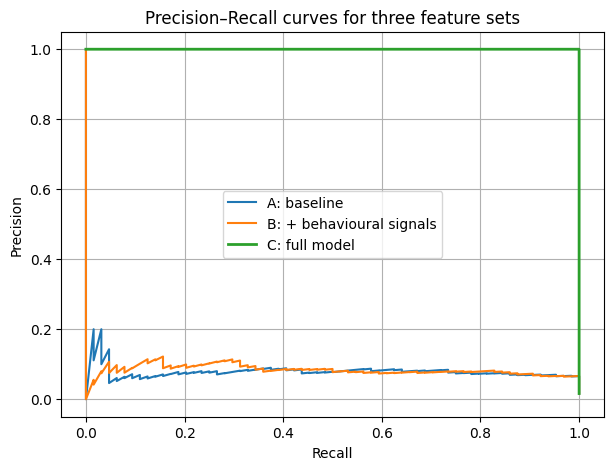

In [28]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def train_xgb_get_scores(feature_list):
    Xtr = train_df[feature_list]
    Xte = test_df[feature_list]

    neg = (y_train == 0).sum()
    pos = (y_train == 1).sum()
    scale = neg / pos

    clf = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        scale_pos_weight=scale,
        random_state=42
    )

    clf.fit(Xtr, y_train)
    prob = clf.predict_proba(Xte)[:, 1]
    return prob

# Reuse the same feature sets
probs_A = train_xgb_get_scores(features_A)
probs_B = train_xgb_get_scores(features_B)
probs_C = train_xgb_get_scores(features_C)

prec_A, rec_A, _ = precision_recall_curve(y_test, probs_A)
prec_B, rec_B, _ = precision_recall_curve(y_test, probs_B)
prec_C, rec_C, _ = precision_recall_curve(y_test, probs_C)

plt.figure(figsize=(7, 5))
plt.plot(rec_A, prec_A, label="A: baseline")
plt.plot(rec_B, prec_B, label="B: + behavioural signals")
plt.plot(rec_C, prec_C, label="C: full model", linewidth=2)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curves for three feature sets")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
def evaluate_threshold(probabilities, threshold):
    pred = (probabilities >= threshold).astype(int)

    precision = precision_score(y_test, pred, zero_division=0)
    recall = recall_score(y_test, pred, zero_division=0)
    f1 = f1_score(y_test, pred, zero_division=0)
    cm = confusion_matrix(y_test, pred)

    tn, fp, fn, tp = cm.ravel()

    return {
        "threshold": threshold,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "false_positives": fp,
        "false_negatives": fn
    }

# Evaluate threshold 0.3, 0.5, 0.7
thresholds = [0.3, 0.5, 0.7]
threshold_results = [evaluate_threshold(probs_C, t) for t in thresholds]

threshold_df = pd.DataFrame(threshold_results)
print(threshold_df)


   threshold  precision  recall   f1  false_positives  false_negatives
0        0.3        1.0     1.0  1.0                0                0
1        0.5        1.0     1.0  1.0                0                0
2        0.7        1.0     1.0  1.0                0                0


In [ ]:
# Training one final XGBoost model on the full feature set (fixed order)
Xtr_final = train_df[features_C]
Xte_final = test_df[features_C]

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale = neg / pos

final_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    scale_pos_weight=scale,
    random_state=42
)

final_model.fit(Xtr_final, y_train)

# Checking how the model behaves across different years (temporal stability)
years = sorted(test_df["year"].unique())
stability_results = []

for yr in years:
    # keep only rows for a single year
    subset = test_df[test_df["year"] == yr]

    X_sub = subset[features_C]
    y_sub = subset["behavior_risk_flag"]

    # model outputs for that year
    prob_sub = final_model.predict_proba(X_sub)[:, 1]
    pred_sub = (prob_sub >= 0.5).astype(int)

    # performance for this slice of time
    precision = precision_score(y_sub, pred_sub, zero_division=0)
    recall = recall_score(y_sub, pred_sub, zero_division=0)
    f1 = f1_score(y_sub, pred_sub, zero_division=0)
    pr_auc = average_precision_score(y_sub, prob_sub)

    stability_results.append({
        "year": yr,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "pr_auc": pr_auc,
        "count": subset.shape[0]
    })

# all yearly scores in one table
stability_df = pd.DataFrame(stability_results)
print(stability_df)


   year  precision  recall   f1  pr_auc  count
0  2023        1.0     1.0  1.0     1.0   1908
1  2024        1.0     1.0  1.0     1.0   2031


In [32]:
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
# building LIME explainer on the final training data
lime_explainer = LimeTabularExplainer(
    Xtr_final.values,
    feature_names=features_C,
    class_names=["safe", "risky"],
    discretize_continuous=True,
    mode="classification",
)

# picking one borrower with label = 1 (high risk) from the test set
risky_indices = y_test[y_test == 1].index
example_idx = risky_indices[0]  

x_instance = Xte_final.loc[example_idx].values
true_label = y_test.loc[example_idx]
pred_prob = final_model.predict_proba(Xte_final.loc[[example_idx]])[0, 1]

print("Example index in test set:", example_idx)
print("True label (0=safe, 1=risky):", true_label)
print("Model probability of risk:", pred_prob)

# asking LIME to explain this prediction
lime_exp = lime_explainer.explain_instance(
    x_instance,
    final_model.predict_proba,
    num_features=8,
)

print("\nLIME explanation (feature -> contribution to risk):")
for feature, weight in lime_exp.as_list():
    print(f"{feature}: {weight:.4f}")


Example index in test set: 10024
True label (0=safe, 1=risky): 1
Model probability of risk: 0.99992085

LIME explanation (feature -> contribution to risk):
missed_payments > 1.00: 0.1444
loan_amount > 990.60: 0.0396
missed_payment_ratio > 0.50: 0.0136
78.20 < consumer_sentiment_index <= 84.31: -0.0030
sentiment_score > 0.23: 0.0028
age_group > 2.00: 0.0026
loan_per_month > 82.55: 0.0017
year_month_num > 202110.00: 0.0012


LIME contributions for the selected risky borrower:


,condition,lime_weight
0,missed_payments > 1.00,0.1444
1,loan_amount > 990.60,0.0396
2,missed_payment_ratio > 0.50,0.0136
3,78.20 < consumer_sentiment_index <= 84.31,-0.0030
4,sentiment_score > 0.23,0.0028
5,age_group > 2.00,0.0026
6,loan_per_month > 82.55,0.0017
7,year_month_num > 202110.00,0.0012


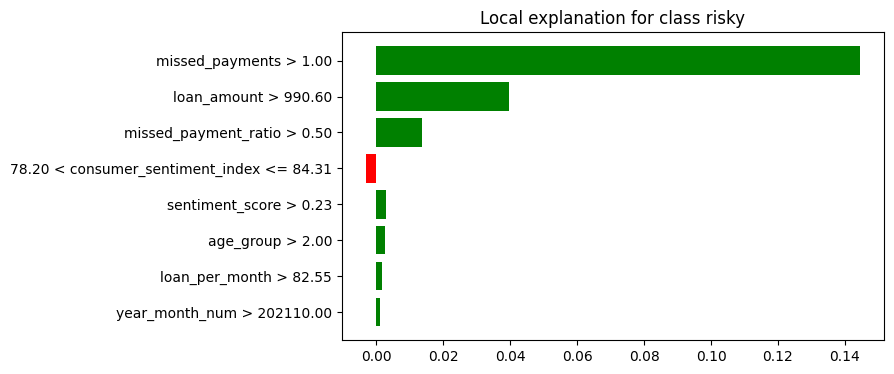

In [34]:
# Bar chart for the current LIME explanation (lime_exp from previous cell)
fig = lime_exp.as_pyplot_figure()
fig.set_figwidth(7)
fig.set_figheight(4)

# Table version
lime_rows = lime_exp.as_list()
lime_df = pd.DataFrame(lime_rows, columns=["condition", "lime_weight"])
lime_df["lime_weight"] = lime_df["lime_weight"].round(4)

print("LIME contributions for the selected risky borrower:")
display(lime_df)


In [35]:
# SHAP vs LIME comparison (same example index as LIME)
example_idx = 10024
x_row = Xte_final.loc[[example_idx]]

# SHAP values for this borrower
shap_values_example = explainer.shap_values(x_row)[0]

shap_df = pd.DataFrame({
    "feature": features_C,
    "shap_value": shap_values_example
})
shap_df["abs_shap"] = shap_df["shap_value"].abs()
top_shap = shap_df.sort_values("abs_shap", ascending=False).head(12)

# LIME table again (use existing lime_df)
lime_df_use = lime_df.copy()
lime_df_use["feature"] = lime_df_use["condition"].apply(
    lambda s: str(s).split(" ")[0]
)

comparison = top_shap.merge(
    lime_df_use[["feature", "lime_weight"]],
    on="feature",
    how="left"
)

comparison["shap_value"] = comparison["shap_value"].round(5)
comparison["abs_shap"] = comparison["abs_shap"].round(5)
comparison["lime_weight"] = comparison["lime_weight"].round(5)

print("SHAP vs LIME Comparison for the Same Borrower:")
display(comparison)


SHAP vs LIME Comparison for the Same Borrower:


,feature,shap_value,abs_shap,lime_weight
0,age_group,5.02890,5.02890,0.0026
1,avg_savings_rate,-1.92358,1.92358,NaN
2,debt_to_income_ratio,-1.79926,1.79926,NaN
3,loan_amount,1.18344,1.18344,0.0396
4,consumer_sentiment_index,0.50904,0.50904,NaN
5,month,0.21097,0.21097,NaN
6,loan_per_month,0.16601,0.16601,0.0017
7,app_used,-0.16443,0.16443,NaN
8,missed_payment_ratio,0.14210,0.14210,0.0136
9,missed_payments,0.10632,0.10632,0.1444


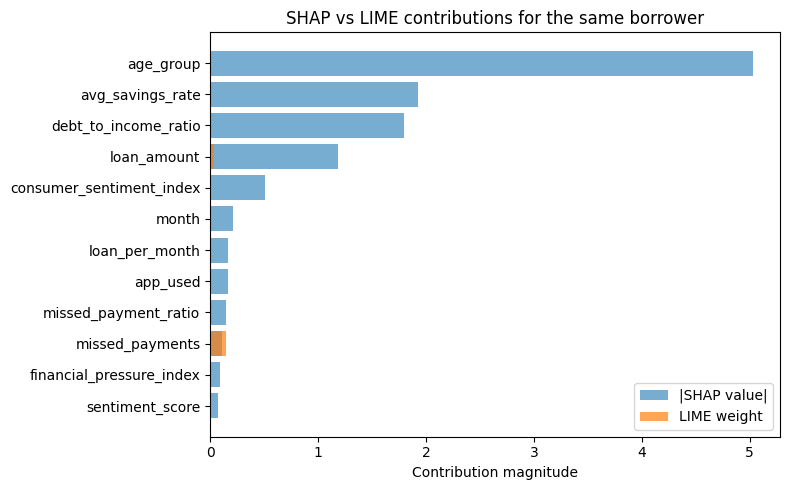

In [36]:
fig, ax = plt.subplots(figsize=(8, 5))

comp_plot = comparison.fillna(0).copy()
comp_plot = comp_plot.sort_values("abs_shap", ascending=True)

y = comp_plot["feature"]

plt.barh(y, comp_plot["abs_shap"], alpha=0.6, label="|SHAP value|")
plt.barh(y, comp_plot["lime_weight"], alpha=0.7, label="LIME weight")

plt.xlabel("Contribution magnitude")
plt.title("SHAP vs LIME contributions for the same borrower")
plt.legend()
plt.tight_layout()
plt.show()



Generating dependence plot for: missed_payments


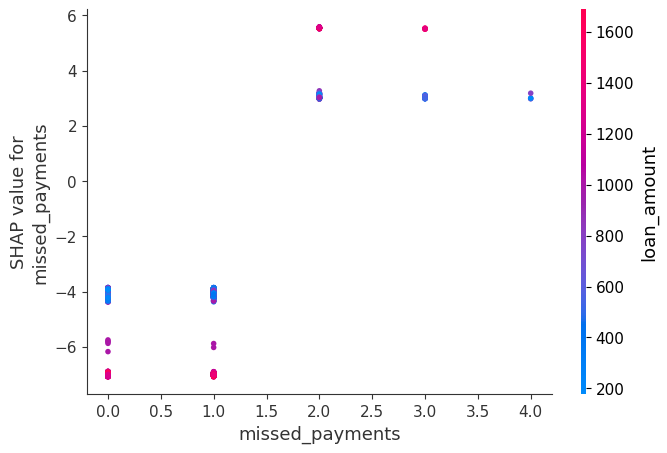


Generating dependence plot for: loan_amount


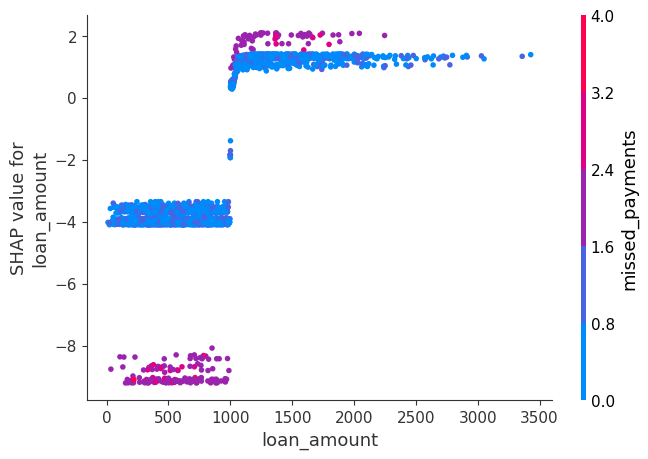


Generating dependence plot for: debt_to_income_ratio


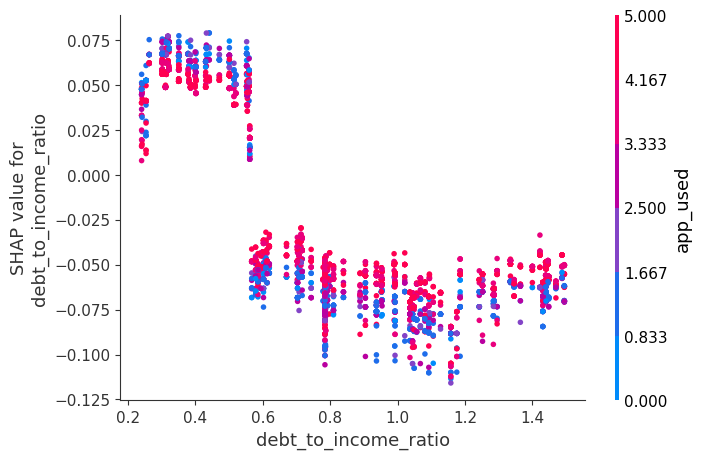

In [37]:
# SHAP Dependence Plots for key financial-risk drivers

key_features = [
    "missed_payments",
    "loan_amount",
    "debt_to_income_ratio"
]

for feat in key_features:
    print(f"\nGenerating dependence plot for: {feat}")
    shap.dependence_plot(
        feat,
        shap_values,
        X_test,
        show=True
    )
